In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

## Helper Functions

In [17]:
def get_admittance_data(path, time_col='ros_time_sec'):
    """
    This function retrieves the admittance data for
    both Monica and Ross from the specified path.

    @param path: The path to the directory containing the csv files.
    @param time_col: The name of the time column to use for merging.
    @param norm_time_col: Whether to normalize the time column
        (subtract each timestamp from the smallest timestamp).

    """
    monica_data = pd.read_csv(os.path.join(path, 'monica_admittance_data.csv'))
    ross_data = pd.read_csv(os.path.join(path, 'ross_admittance_data.csv'))

    # save everything to a single dataframe
    time_series_df = pd.merge(
        monica_data,
        ross_data,
        on=time_col,
        how='outer',
        # appends suffixes to the column names
        # from the original dataframes
        suffixes=('_monica', '_ross')
    ).sort_values(time_col).reset_index(drop=True)

    # fill in null values
    # time_series = time_series.set_index('time_sec')
    # time_series = time_series.interpolate(method='time').reset_index()
    time_series_df = time_series_df.interpolate(method='linear')
    # fill in NaN values
    time_series_df = time_series_df.bfill()

    return time_series_df

def merge_traj_and_admittance_data(
    traj_df, admittance_df,
    time_col='ros_time_sec', tolerance=0.01,
    norm_time_col=False):
    """
    Merge the trajectory and admittance data on the time column.

    @param traj_df: The trajectory dataframe.
    @param admittance_df: The admittance dataframe.
    @param norm_time_col: Whether to normalize the time columns.
    @return: The merged dataframe.
    """

    if norm_time_col:
        traj_df[time_col] = (
            traj_df[time_col] - traj_df[time_col].min()
        ) / (traj_df[time_col].max() - traj_df[time_col].min())

        admittance_df[time_col] = (
            admittance_df[time_col] - admittance_df[time_col].min()
        ) / (admittance_df[time_col].max() - admittance_df[time_col].min())

    merged_df = pd.merge_asof(
        traj_df,
        admittance_df,
        on=time_col,
        direction='nearest',
        tolerance=tolerance
        # dataframes share no important columns
        # so this is unnecessary
        # suffixes=('_traj', '_admittance')
    )
    return merged_df


def align_trial_to_grid(df, time_col, n_samples, columns):
    """Interpolate trial data onto a normalized time grid."""
    # Time grid [0, 1]
    sample_points = np.linspace(0, 1, n_samples)
    # DataFrame to hold interpolated values
    trial_samples = pd.DataFrame({time_col: sample_points})

    # For each column,
    for col in columns:
        # Use interpolation to fill in values
        # at the sample points
        # This allows us to handle data with slightly
        # different timestamps
        trial_samples[col] = np.interp(
            sample_points,
            df[time_col],
            df[col]
        )
    return trial_samples

def get_stats(paths,
    time_col='ros_time_sec',
    n_samples=100,
    tolerance=None,
    add_nans=False):
    """
    Retrieves and computes statistics from trajectory and admittance data across multiple trials.

    @param paths: List of directories containing trial data.
    @param time_col: Name of the time column (should be normalized to [0, 1]).
    @param n_samples: Number of equally spaced samples to take per trial.
    @return: Dictionary with 'mean' and 'std' DataFrames, indexed by normalized_time.
    """
    columns_to_sample = [
        'act_ross_x', 'act_ross_y', 'act_mon_x', 'act_mon_y',
        'act_payload_x', 'act_payload_y', 'force_monica', 'force_ross'
    ]
    resampled_trials = []

    for trial in paths:
        # Load the data
        try:
            traj_df = pd.read_csv(os.path.join(trial, 'trajectory_data.csv'))
            admittance_df = get_admittance_data(trial, time_col=time_col)
        
        # handle missing files
        except FileNotFoundError:
            print(f"Skipping trial {trial}: Required data files not found.")
            continue

        # handle empty of malformed files
        except Exception as e:
            print(f"Skipping trial {trial}: {e}")
            continue

        # Merge trajectory and admittance data
        # normalize time column to [0, 1]
        merged_df = merge_traj_and_admittance_data(
            traj_df,
            admittance_df,
            time_col=time_col,
            tolerance=tolerance,
            # Always normalize
            norm_time_col=True
        )

        # Interpolate each column to the common time grid
        trial_samples = align_trial_to_grid(merged_df, time_col, n_samples, columns_to_sample)

        # Add the resampled trial to the list
        resampled_trials.append(trial_samples)

    if add_nans:
        # Shape: (n_trials, n_samples, n_features)
        stacked = np.stack([df.drop(columns=[time_col]).values for df in resampled_trials])

        # Common time grid (same for all trials)
        time_grid = resampled_trials[0][time_col].values

        # Compute mean/std across trials, ignoring NaNs
        mean = np.nanmean(stacked, axis=0)   # shape (n_samples, n_features)
        std  = np.nanstd(stacked, axis=0)    # shape (n_samples, n_features)

        # Wrap back into DataFrames for consistency
        mean_df = pd.DataFrame(mean, columns=resampled_trials[0].columns.drop(time_col))
        std_df  = pd.DataFrame(std,  columns=resampled_trials[0].columns.drop(time_col))

        mean_df.insert(0, time_col, time_grid)
        std_df.insert(0, time_col, time_grid)

        stats = {"mean": mean_df, "std": std_df}

    else:
        # Combine all trials and compute statistics
        combined_df = pd.concat(resampled_trials, ignore_index=True)
        stats = {
            "mean": combined_df.groupby(time_col).mean(),
            "std": combined_df.groupby(time_col).std()
        }
    
    return stats

## Plotting Functions

In [18]:
def plot_traj_and_force(
        merged_df,
        time_col='ros_time_sec',
        fig_size=(18, 8),
        ross_color='blue',
        monica_color='red',
        payload_color='green',
        desired_line_style='-',
        actual_line_style='--'
    ):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=fig_size,
    )

    # plot trajectories
    axes[0].plot(
        merged_df['act_mon_x'],
        merged_df['act_mon_y'],
        label='Monica\'s actual trajectory',
        color=monica_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['des_mon_x'],
        merged_df['des_mon_y'],
        label='Monica\'s desired trajectory',
        color=monica_color,
        linestyle=desired_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['act_ross_x'],
        merged_df['act_ross_y'],
        label='Ross\'s actual trajectory',
        color=ross_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['des_ross_x'],
        merged_df['des_ross_y'],
        label='Ross\'s desired trajectory',
        color=ross_color,
        linestyle=desired_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['act_payload_x'],
        merged_df['act_payload_y'],
        label='Payload\'s actual trajectory',
        color=payload_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].set_xlabel('X (m)')
    axes[0].set_ylabel('Y (m)')
    axes[0].set_title('Actual Trajectories')
    axes[0].legend()
    axes[0].grid(True)

    # plot forces
    axes[1].plot(
        merged_df['act_payload_x'],
        merged_df['force_monica'],
        label="Monica's force",
        color=monica_color
    )
    axes[1].plot(
        merged_df['act_payload_x'],
        merged_df['force_ross'],
        label="Ross's force",
        color=ross_color
    )
    axes[1].set_xlabel('Payload X Position (m)')
    axes[1].set_ylabel('Force (N)')
    axes[1].set_title('Force vs Payload X Position')
    axes[1].legend()
    axes[1].grid(True)

    fig.tight_layout()


def plot_stats(
        stats,
        traj_df=None,
        fig_size=(18, 8),
        ross_color='blue',
        monica_color='red',
        payload_color='green',
        desired_line_style='-',
        actual_line_style='--',
        file_name=None
    ):
    """
    Plots the mean and standard deviation of trajectory and force data over normalized time.

    @param stats: A dictionary containing 'mean' and 'std' DataFrames, indexed by normalized_time.
    """
    if stats is None or 'mean' not in stats or 'std' not in stats:
        print("Invalid stats dictionary provided. Cannot plot.")
        return

    mean_df = stats['mean']
    std_df = stats['std']

    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=fig_size,
    )

    # --- Trajectories ---
    axes[0].plot(
        mean_df['act_mon_x'],
        mean_df['act_mon_y'],
        label="Monica's mean trajectory",
        color=monica_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].fill_between(
        mean_df['act_mon_x'],
        mean_df['act_mon_y'] - std_df['act_mon_y'],
        mean_df['act_mon_y'] + std_df['act_mon_y'],
        color=monica_color,
        alpha=0.2,
        label="Monica's std dev"
    )
    axes[0].plot(
        mean_df['act_ross_x'],
        mean_df['act_ross_y'],
        label="Ross's mean trajectory",
        color=ross_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].fill_between(
        mean_df['act_ross_x'],
        mean_df['act_ross_y'] - std_df['act_ross_y'],
        mean_df['act_ross_y'] + std_df['act_ross_y'],
        color=ross_color,
        alpha=0.2,
        label="Ross's std dev"
    )
    axes[0].plot(
        mean_df['act_payload_x'],
        mean_df['act_payload_y'],
        label="Payload's mean trajectory",
        color=payload_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].fill_between(
        mean_df['act_payload_x'],
        mean_df['act_payload_y'] - std_df['act_payload_y'],
        mean_df['act_payload_y'] + std_df['act_payload_y'],
        color=payload_color,
        alpha=0.2,
        label="Payload's std dev"
    )
    # desired trajectories
    if traj_df is not None:
        axes[0].plot(
            traj_df['des_mon_x'],
            traj_df['des_mon_y'],
            label="Monica's desired trajectory",
            color=monica_color,
            linestyle=desired_line_style
        )
        axes[0].plot(
            traj_df['des_ross_x'],
            traj_df['des_ross_y'],
            label="Ross's desired trajectory",
            color=ross_color,
            linestyle=desired_line_style
        )
    axes[0].set_xlabel('X (m)')
    axes[0].set_ylabel('Y (m)')
    axes[0].set_title('Mean Trajectories with Std. Dev.')
    axes[0].legend()
    axes[0].grid(True)

    # --- Forces ---
    axes[1].plot(
        mean_df['act_payload_x'],
        mean_df['force_monica'],
        label="Monica's mean force",
        color=monica_color
    )
    axes[1].fill_between(
        mean_df['act_payload_x'],
        mean_df['force_monica'] - std_df['force_monica'],
        mean_df['force_monica'] + std_df['force_monica'],
        color=monica_color,
        alpha=0.2,
        label="Monica's force std dev"
    )
    axes[1].plot(
        mean_df['act_payload_x'],
        mean_df['force_ross'],
        label="Ross's mean force",
        color=ross_color
    )
    axes[1].fill_between(
        mean_df['act_payload_x'],
        mean_df['force_ross'] - std_df['force_ross'],
        mean_df['force_ross'] + std_df['force_ross'],
        color=ross_color,
        alpha=0.2,
        label="Ross's force std dev"
    )
    axes[1].set_xlabel('Payload X Position (m)')
    axes[1].set_ylabel('Force (N)')
    axes[1].set_title('Mean Forces with Std. Dev.')
    axes[1].legend()
    axes[1].grid(True)

    fig.tight_layout()
    if file_name is not None:
        plt.savefig(fname=file_name, dpi=300)

## Plotting / Data Analysis

In [19]:
csv_path = '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_02/'
time_col = 'ros_time_ns'
norm_time_col = True
# tolerance = 1_000_000 # 1 ms
tolerance = 0.001  # 1 ms

traj_df = pd.read_csv(csv_path + 'trajectory_data.csv')

traj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   des_ross_x                1501 non-null   float64
 1   des_ross_y                1501 non-null   float64
 2   des_ross_theta            1501 non-null   float64
 3   des_mon_x                 1501 non-null   float64
 4   des_mon_y                 1501 non-null   float64
 5   des_mon_theta             1501 non-null   float64
 6   act_ross_x                1501 non-null   float64
 7   act_ross_y                1501 non-null   float64
 8   act_ross_theta            1501 non-null   float64
 9   act_mon_x                 1501 non-null   float64
 10  act_mon_y                 1501 non-null   float64
 11  act_mon_theta             1501 non-null   float64
 12  act_payload_x             1501 non-null   float64
 13  act_payload_y             1501 non-null   float64
 14  act_payl

In [20]:
admittance_df = get_admittance_data(csv_path, time_col=time_col)

admittance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75926 entries, 0 to 75925
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   t_p_x_monica         75926 non-null  float64
 1   t_p_y_monica         75926 non-null  float64
 2   t_p_z_monica         75926 non-null  float64
 3   t_w_monica           75926 non-null  float64
 4   t_x_monica           75926 non-null  float64
 5   t_y_monica           75926 non-null  float64
 6   t_z_monica           75926 non-null  float64
 7   v_p_x_monica         75926 non-null  float64
 8   v_p_y_monica         75926 non-null  float64
 9   v_p_z_monica         75926 non-null  float64
 10  v_w_monica           75926 non-null  float64
 11  v_x_monica           75926 non-null  float64
 12  v_y_monica           75926 non-null  float64
 13  v_z_monica           75926 non-null  float64
 14  force_monica         75926 non-null  float64
 15  stiffness_monica     75926 non-null 

In [21]:
merged_df = merge_traj_and_admittance_data(
    traj_df,
    admittance_df,
    time_col=time_col,
    tolerance=tolerance,
    norm_time_col=norm_time_col
)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   des_ross_x                1501 non-null   float64
 1   des_ross_y                1501 non-null   float64
 2   des_ross_theta            1501 non-null   float64
 3   des_mon_x                 1501 non-null   float64
 4   des_mon_y                 1501 non-null   float64
 5   des_mon_theta             1501 non-null   float64
 6   act_ross_x                1501 non-null   float64
 7   act_ross_y                1501 non-null   float64
 8   act_ross_theta            1501 non-null   float64
 9   act_mon_x                 1501 non-null   float64
 10  act_mon_y                 1501 non-null   float64
 11  act_mon_theta             1501 non-null   float64
 12  act_payload_x             1501 non-null   float64
 13  act_payload_y             1501 non-null   float64
 14  act_payl

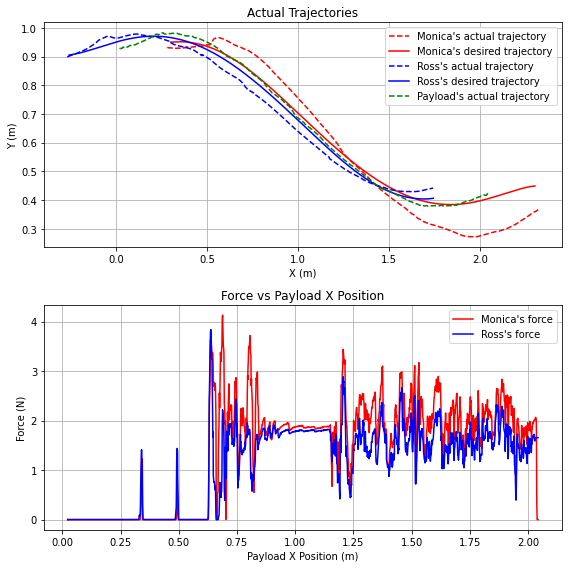

In [22]:
plot_traj_and_force(merged_df, fig_size=(8, 8))

## Left and right mean + std. dev plots (no desired trajectory)

In [23]:
base_path = '../../data/08-30_dataset/08-30_dp_experiments/'
dirs = os.listdir(base_path)

# Match directories ending with '01' to '15'
pattern = re.compile(r'01$|02$|03$|04$|05$|06$|07$|08$|09$|10$|11$|12$|13$|14$|15$')
filtered_dirs = [
    os.path.join(base_path, d)
    for d in dirs
    if pattern.search(d)
]

print(filtered_dirs)
stats = get_stats(
    filtered_dirs,
    time_col=time_col,
    n_samples=100,
    tolerance=tolerance,
    add_nans=False
)

['../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_15', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_01', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_03', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_04', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_13', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_07', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_08', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_12', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_05', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_14', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_11', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_02', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_09', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_10', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial

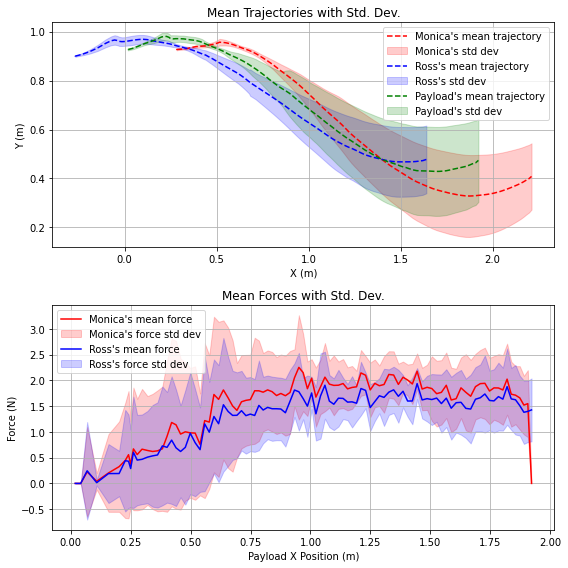

In [24]:
plot_stats(stats, fig_size=(8, 8), file_name='traj_forces_plot_right_no_desired_traj.png')

In [25]:
base_path = '../../data/08-30_dataset/08-30_dp_experiments/'
dirs = os.listdir(base_path)

# Match directories ending with '16' to '30'
pattern = re.compile(
    r'16$|17$|18$|19$|20$|21$|22$|23$|24$|25$|26$|27$|28$|29$|30$')
filtered_dirs = [
    os.path.join(base_path, d)
    for d in dirs
    if pattern.search(d)
]

print(filtered_dirs)
stats = get_stats(
    filtered_dirs,
    time_col=time_col,
    n_samples=100,
    tolerance=tolerance,
    add_nans=False
)

traj_df = pd.read_csv(os.path.join(filtered_dirs[0], 'trajectory_data.csv'))

['../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_19', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_20', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_18', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_25', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_26', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_23', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_16', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_24', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_22', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_17', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_21']


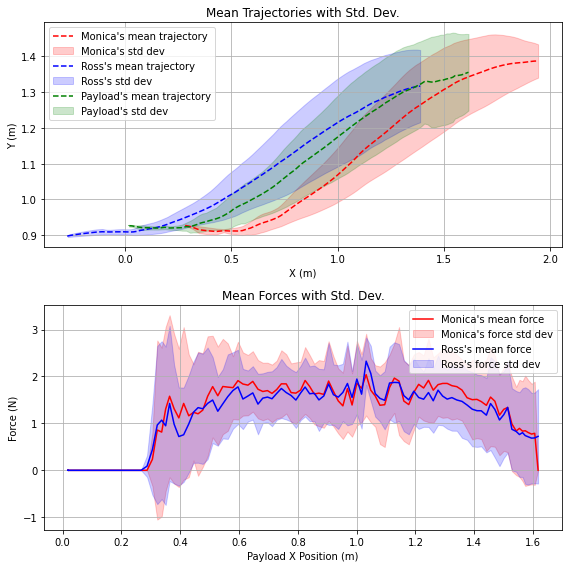

In [26]:
plot_stats(stats, fig_size=(8, 8),
           file_name='traj_forces_plot_left_no_desired_traj.png')

## Left and right mean + std. dev plots (with desired trajectory)

In [27]:
base_path = '../../data/08-30_dataset/08-30_dp_experiments/'
dirs = os.listdir(base_path)

# Match directories ending with '01' to '15'
pattern = re.compile(
    r'01$|02$|03$|04$|05$|06$|07$|08$|09$|10$|11$|12$|13$|14$|15$')
filtered_dirs = [
    os.path.join(base_path, d)
    for d in dirs
    if pattern.search(d)
]

print(filtered_dirs)
stats = get_stats(
    filtered_dirs,
    time_col=time_col,
    n_samples=100,
    tolerance=tolerance,
    add_nans=False
)

traj_df = pd.read_csv(os.path.join(filtered_dirs[0], 'trajectory_data.csv'))

['../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_15', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_01', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_03', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_04', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_13', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_07', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_08', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_12', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_05', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_14', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_11', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_02', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_09', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_10', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial

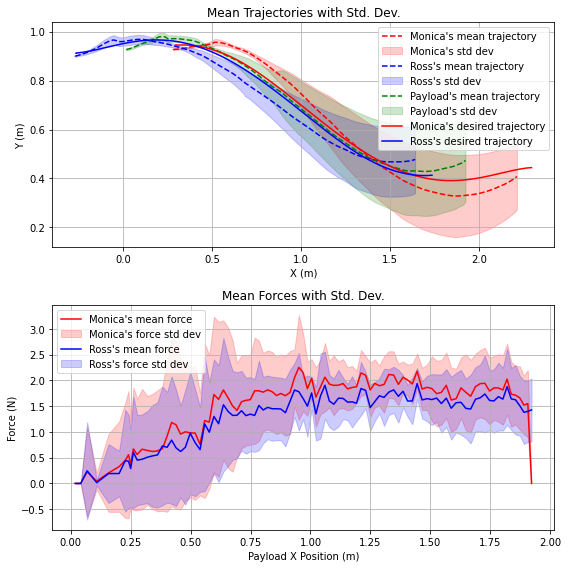

In [28]:
plot_stats(stats, traj_df, fig_size=(8, 8), file_name='traj_forces_plot_right_with_desired_traj.png')

In [29]:
base_path = '../../data/08-30_dataset/08-30_dp_experiments/'
dirs = os.listdir(base_path)

# Match directories ending with '16' to '30'
pattern = re.compile(
    r'16$|17$|18$|19$|20$|21$|22$|23$|24$|25$|26$|27$|28$|29$|30$')
filtered_dirs = [
    os.path.join(base_path, d)
    for d in dirs
    if pattern.search(d)
]

print(filtered_dirs)
stats = get_stats(
    filtered_dirs,
    time_col=time_col,
    n_samples=100,
    tolerance=tolerance,
    add_nans=False
)

traj_df = pd.read_csv(os.path.join(filtered_dirs[0], 'trajectory_data.csv'))

['../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_19', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_20', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_18', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_25', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_26', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_23', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_16', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_24', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_22', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_17', '../../data/08-30_dataset/08-30_dp_experiments/08-30_dp_trial_21']


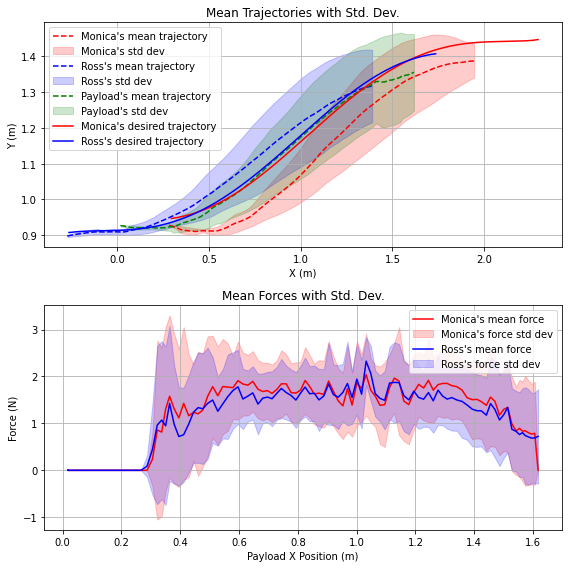

In [30]:
plot_stats(stats, traj_df, fig_size=(8, 8), file_name='traj_forces_plot_left_with_desired_traj.png')